37/37 [==============================] - 0s 623us/step
Train accuracy: 0.838176515069677
Test accuracy: 0.8365051903114187
290/290 [==============================] - 0s 585us/step
Epoch 1/120
521/521 [==============================] - 22s 15ms/step - loss: 22.4413 - val_loss: 17.8873
Epoch 2/120
521/521 [==============================] - 1s 2ms/step - loss: 15.4755 - val_loss: 14.4984
Epoch 3/120
521/521 [==============================] - 1s 2ms/step - loss: 15.2257 - val_loss: 15.8547
Epoch 4/120
521/521 [==============================] - 1s 2ms/step - loss: 16.5064 - val_loss: 16.9439
Epoch 5/120
521/521 [==============================] - 1s 2ms/step - loss: 16.8769 - val_loss: 17.0596
Epoch 6/120
521/521 [==============================] - 1s 2ms/step - loss: 16.9158 - val_loss: 17.1510
Epoch 7/120
521/521 [==============================] - 1s 2ms/step - loss: 17.3160 - val_loss: 17.6037
Epoch 8/120
521/521 [==============================] - 1s 2ms/step - loss: 17.5753 - val_loss: 17

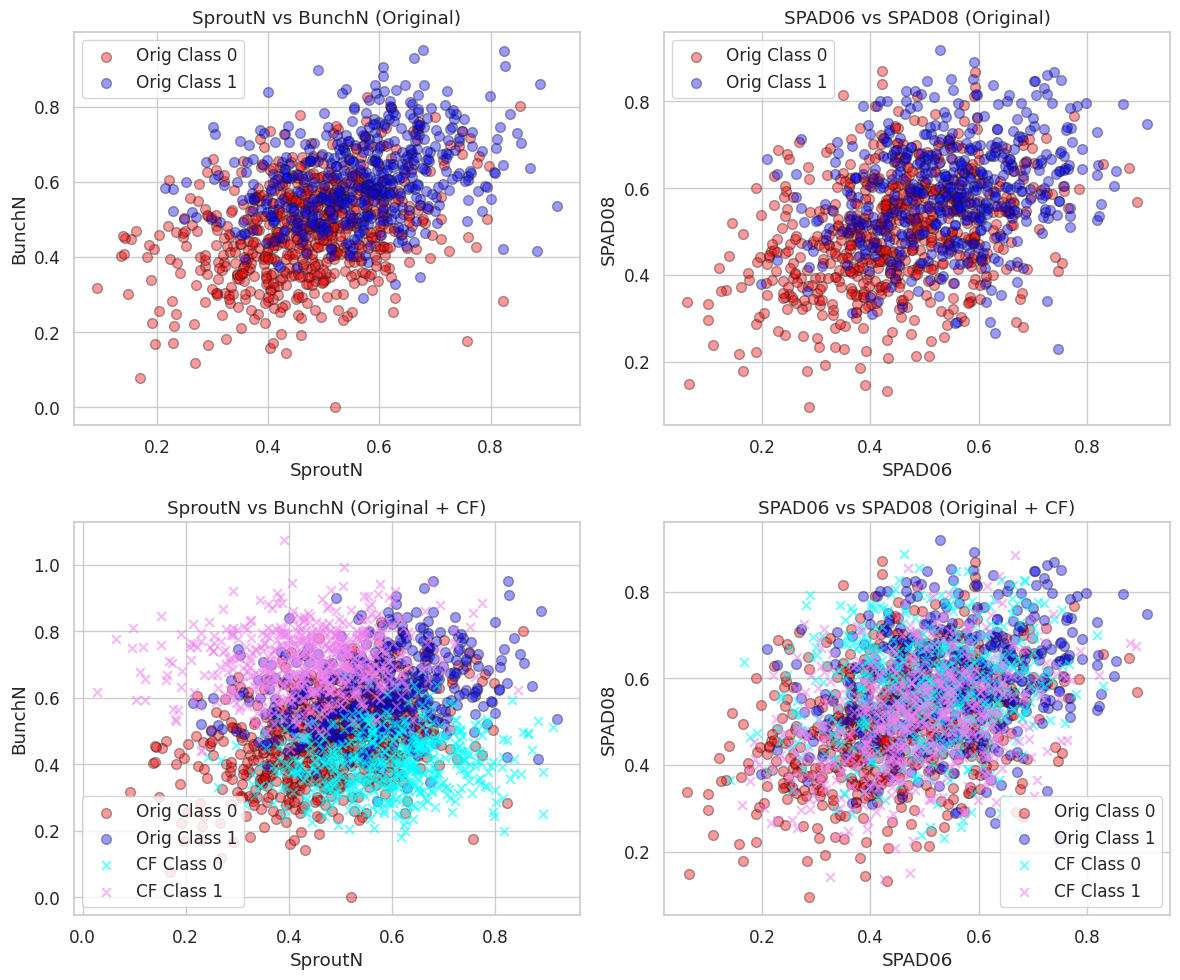

37/37 [==============================] - 0s 588us/step

Metrics Table:
--------------------------------------------------
| Metric    | Value   |
--------------------------------------------------
| Validity  | 1.0000 |
| Distance  | 0.3369 |
| CES       | -0.6430 |
| DPS       | 0.4394 |
| IM1       | 0.6643 |
--------------------------------------------------


In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import norm
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

# Constants
N_FEATURES = 13
LATENT_DIM = 15
BINS = 50
LAMBDA_CLASSIFICATION = 3.0
LAMBDA_MI = 10.0
LAMBDA_MSE = 6.5
LAMBDA_KL = 0.0001
EPOCHS = 120
BATCH_SIZE = 16
LEARNING_RATE = 5e-4
FEATURE_NAMES = [
    "SproutN", "BunchN", "ShootL", "NodeN", "SPAD06",
    "SPAD07", "SPAD08", "LWC", "ChlA", "ChlB",
    "Carot", "Anth", "Phenol"
]

def load_data():
    """Load Sangiovese dataset from numpy files."""
    data_train = np.load('sangiovese-train-set.npy')
    data_val = np.load('sangiovese-val-set.npy')
    data_test = np.load('sangiovese-test-set.npy')
    
    X_train = data_train[:, :-1]
    y_train = data_train[:, -1]
    X_val = data_val[:, :-1]
    y_val = data_val[:, -1]
    X_test = data_test[:, :-1]
    y_test = data_test[:, -1]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

def compute_feature_weights(X_train):
    """Compute feature weights based on standard deviation."""
    feature_std = np.std(X_train, axis=0)
    return 1.0 / feature_std

def estimate_mi(x, y, bins=BINS):
    """Estimate mutual information between two features using histograms."""
    hist_2d, x_edges, y_edges = np.histogram2d(x, y, bins=bins, density=True)
    p_xy = hist_2d / np.sum(hist_2d)
    p_x = np.sum(p_xy, axis=1)
    p_y = np.sum(p_xy, axis=0)
    p_x_p_y = np.outer(p_x, p_y)
    valid = (p_xy > 0) & (p_x_p_y > 0)
    mi = np.sum(p_xy[valid] * np.log(p_xy[valid] / p_x_p_y[valid]))
    return mi

def compute_mi_and_ranges(X_train, bins=BINS):
    """Precompute mutual information and feature ranges."""
    n_features = X_train.shape[1]
    mi_original = {}
    feature_ranges = {}
    for i, j in combinations(range(n_features), 2):
        mi = estimate_mi(X_train[:, i], X_train[:, j], bins=bins)
        mi_original[(i, j)] = mi
        feature_ranges[(i, j)] = (
            min(X_train[:, i].min(), X_train[:, j].min()),
            max(X_train[:, i].max(), X_train[:, j].max())
        )
    return mi_original, feature_ranges

class MILossLayer(keras.layers.Layer):
    """Custom layer for mutual information loss."""
    def __init__(self, bins, feature_ranges, mi_original_tf, lambda_mi, **kwargs):
        super(MILossLayer, self).__init__(**kwargs)
        self.bins = bins
        self.feature_ranges = feature_ranges
        self.mi_original_tf = mi_original_tf
        self.lambda_mi = lambda_mi

    def call(self, inputs):
        x_recon = inputs
        mi_loss = 0.0
        n_pairs = len(self.mi_original_tf)

        for i, j in combinations(range(x_recon.shape[1]), 2):
            x_i = x_recon[:, i]
            x_j = x_recon[:, j]
            vmin, vmax = self.feature_ranges[(i, j)]
            vmin = tf.constant(vmin, dtype=tf.float32)
            vmax = tf.constant(vmax, dtype=tf.float32)
            bin_edges = tf.linspace(vmin, vmax, self.bins + 1)
            x_i_bin = tf.searchsorted(bin_edges, x_i, side='right') - 1
            x_j_bin = tf.searchsorted(bin_edges, x_j, side='right') - 1
            x_i_bin = tf.clip_by_value(x_i_bin, 0, self.bins - 1)
            x_j_bin = tf.clip_by_value(x_j_bin, 0, self.bins - 1)
            flat_indices = x_i_bin * self.bins + x_j_bin

            hist_1d = tf.math.bincount(
                tf.cast(flat_indices, tf.int32), minlength=self.bins * self.bins, dtype=tf.float32
            )
            hist_2d = tf.reshape(hist_1d, (self.bins, self.bins))
            p_xy = hist_2d / (tf.reduce_sum(hist_2d) + 1e-10)
            p_x = tf.reduce_sum(p_xy, axis=1) + 1e-10
            p_y = tf.reduce_sum(p_xy, axis=0) + 1e-10
            p_x_p_y = tf.expand_dims(p_x, 1) * tf.expand_dims(p_y, 0)
            valid = (p_xy > 1e-10) & (p_x_p_y > 1e-10)
            mi = tf.reduce_sum(tf.where(valid, p_xy * tf.math.log(p_xy / (p_x_p_y + 1e-10)), 0.0))
            mi_loss += tf.abs(mi - self.mi_original_tf[(i, j)])

        mi_loss = mi_loss / n_pairs
        self.add_loss(self.lambda_mi * mi_loss)
        return x_recon

def build_encoder(latent_dim=LATENT_DIM):
    """Build the encoder model."""
    encoder_inputs = keras.Input(shape=(N_FEATURES,), name='X')
    x = keras.layers.Dense(54, activation='relu')(encoder_inputs)
    x = keras.layers.Dense(32, activation='relu')(x)
    x = keras.layers.Dense(16, activation='relu')(x)
    mu = keras.layers.Dense(latent_dim, name='mu')(x)
    log_var = keras.layers.Dense(latent_dim, name='log_var')(x)
    return keras.Model(encoder_inputs, [mu, log_var], name='encoder')

def build_decoder(latent_dim=LATENT_DIM):
    """Build the decoder model."""
    z_inputs = keras.Input(shape=(latent_dim,), name='z')
    t_inputs = keras.Input(shape=(1,), name='t')
    decoder_inputs = keras.layers.Concatenate(name='decoder_input')([z_inputs, t_inputs])
    x = keras.layers.Dense(16, activation='relu')(decoder_inputs)
    x = keras.layers.Dense(32, activation='relu')(x)
    x = keras.layers.Dense(64, activation='relu')(x)
    x_recon = keras.layers.Dense(N_FEATURES, name='X_recon')(x)
    return keras.Model([z_inputs, t_inputs], x_recon, name='decoder')

def build_vae(encoder, decoder, clf, mi_original_tf, feature_ranges, feature_weights, 
              lambda_classification=LAMBDA_CLASSIFICATION, lambda_mi=LAMBDA_MI, 
              lambda_mse=LAMBDA_MSE, lambda_kl=LAMBDA_KL, bins=BINS):
    """Build and compile the VAE model."""
    vae_inputs = keras.Input(shape=(N_FEATURES,), name='X_input')
    t_inputs = keras.Input(shape=(1,), name='t_input')
    mu, log_var = encoder(vae_inputs)
    epsilon = tf.keras.backend.random_normal(shape=(tf.shape(mu)[0], LATENT_DIM))
    z = mu + tf.exp(0.5 * log_var) * epsilon
    x_recon = decoder([z, t_inputs])
    x_recon = MILossLayer(bins=bins, feature_ranges=feature_ranges, 
                          mi_original_tf=mi_original_tf, lambda_mi=lambda_mi)(x_recon)
    vae = keras.Model([vae_inputs, t_inputs], x_recon, name='vae')

    # KL Divergence Loss
    kl_loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var), axis=-1)
    vae.add_loss(lambda_kl * tf.reduce_mean(kl_loss))

    # Classification Loss
    p = clf(x_recon)
    classification_loss = tf.keras.losses.sparse_categorical_crossentropy(t_inputs, p)
    vae.add_loss(lambda_classification * tf.reduce_mean(classification_loss))

    # Reconstruction Loss (Weighted MSE)
    def weighted_mse(y_true, y_pred):
        return tf.reduce_mean(feature_weights * tf.square(y_true - y_pred), axis=-1)

    mse_loss = weighted_mse(vae_inputs, x_recon)
    vae.add_loss(lambda_mse * tf.reduce_mean(mse_loss))

    # Freeze classifier layers
    for layer in clf.layers:
        layer.trainable = False

    vae.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))
    return vae

def evaluate_classifier(clf, X_train, y_train, X_test, y_test):
    """Evaluate the pre-trained classifier."""
    y_train_pred = np.argmax(clf.predict(X_train), axis=1)
    y_test_pred = np.argmax(clf.predict(X_test), axis=1)
    print("Train accuracy:", accuracy_score(y_train, y_train_pred))
    print("Test accuracy:", accuracy_score(y_test, y_test_pred))

def generate_counterfactuals(vae, clf, X_test):
    """Generate and verify counterfactuals, including class flipping percentage."""
    original_probs = clf.predict(X_test)
    original_classes = np.argmax(original_probs, axis=1)
    t_test = (1 - original_classes).reshape(-1, 1).astype(np.float32)
    X_test_recon = vae.predict([X_test, t_test])
    counterfactual_probs = clf.predict(X_test_recon)
    counterfactual_classes = np.argmax(counterfactual_probs, axis=1)
    flipped = (original_classes != counterfactual_classes).astype(int)
    flip_percentage = np.mean(flipped) * 100
    print(f"Percentage of test samples that flipped their predicted class: {flip_percentage:.2f}%")
    return X_test_recon, t_test, original_classes, counterfactual_classes

def visualize_counterfactuals(X_test, y_test, X_test_recon, counterfactual_classes):
    """Visualize counterfactuals against original data."""
    sns.set(style="whitegrid", font_scale=1.1)
    idx0 = np.where(y_test == 0)[0]
    idx1 = np.where(y_test == 1)[0]
    idxcf_0 = np.where(counterfactual_classes == 0)[0]
    idxcf_1 = np.where(counterfactual_classes == 1)[0]

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # SproutN vs BunchN (Original)
    axes[0, 0].scatter(X_test[idx0, 0], X_test[idx0, 1], c='red', label='Orig Class 0', alpha=0.4, edgecolors='k', s=50)
    axes[0, 0].scatter(X_test[idx1, 0], X_test[idx1, 1], c='blue', label='Orig Class 1', alpha=0.4, edgecolors='k', s=50)
    axes[0, 0].set_title("SproutN vs BunchN (Original)")
    axes[0, 0].set_xlabel("SproutN")
    axes[0, 0].set_ylabel("BunchN")
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # SPAD06 vs SPAD08 (Original)
    axes[0, 1].scatter(X_test[idx0, 4], X_test[idx0, 6], c='red', label='Orig Class 0', alpha=0.4, edgecolors='k', s=50)
    axes[0, 1].scatter(X_test[idx1, 4], X_test[idx1, 6], c='blue', label='Orig Class 1', alpha=0.4, edgecolors='k', s=50)
    axes[0, 1].set_title("SPAD06 vs SPAD08 (Original)")
    axes[0, 1].set_xlabel("SPAD06")
    axes[0, 1].set_ylabel("SPAD08")
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # SproutN vs BunchN (Original + CF)
    axes[1, 0].scatter(X_test[idx0, 0], X_test[idx0, 1], c='red', label='Orig Class 0', alpha=0.4, edgecolors='k', s=50)
    axes[1, 0].scatter(X_test[idx1, 0], X_test[idx1, 1], c='blue', label='Orig Class 1', alpha=0.4, edgecolors='k', s=50)
    axes[1, 0].scatter(X_test_recon[idxcf_0, 0], X_test_recon[idxcf_0, 1], c='aqua', label='CF Class 0', alpha=0.55, marker='x', s=40)
    axes[1, 0].scatter(X_test_recon[idxcf_1, 0], X_test_recon[idxcf_1, 1], c='violet', label='CF Class 1', alpha=0.55, marker='x', s=40)
    axes[1, 0].set_title("SproutN vs BunchN (Original + CF)")
    axes[1, 0].set_xlabel("SproutN")
    axes[1, 0].set_ylabel("BunchN")
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # SPAD06 vs SPAD08 (Original + CF)
    axes[1, 1].scatter(X_test[idx0, 4], X_test[idx0, 6], c='red', label='Orig Class 0', alpha=0.4, edgecolors='k', s=50)
    axes[1, 1].scatter(X_test[idx1, 4], X_test[idx1, 6], c='blue', label='Orig Class 1', alpha=0.4, edgecolors='k', s=50)
    axes[1, 1].scatter(X_test_recon[idxcf_0, 4], X_test_recon[idxcf_0, 6], c='aqua', label='CF Class 0', alpha=0.55, marker='x', s=40)
    axes[1, 1].scatter(X_test_recon[idxcf_1, 4], X_test_recon[idxcf_1, 6], c='violet', label='CF Class 1', alpha=0.55, marker='x', s=40)
    axes[1, 1].set_title("SPAD06 vs SPAD08 (Original + CF)")
    axes[1, 1].set_xlabel("SPAD06")
    axes[1, 1].set_ylabel("SPAD08")
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

def compute_causal_edge_score(CF, X_test):
    """Compute Causal Edge Score (CES) for Sangiovese."""
    def compute_log_likelihood(value, mean, std):
        return norm.logpdf(value, loc=mean, scale=std)

    def compute_all_log_likelihoods(X):
        SproutN = X[:, 0]
        BunchN = X[:, 1]
        SPAD06 = X[:, 4]
        SPAD08 = X[:, 6]
        ll = np.zeros_like(SproutN)
        a1, b1, std1 = 1.0, 0.0, 0.2  # Placeholder values
        ll += compute_log_likelihood(BunchN, a1 * SproutN + b1, std1)
        a2, b2, std2 = 1.0, 0.0, 0.2  # Placeholder values
        ll += compute_log_likelihood(SPAD08, a2 * SPAD06 + b2, std2)
        return ll

    CF_np = CF.to_numpy()
    ll_cf = compute_all_log_likelihoods(CF_np)
    ll_x = compute_all_log_likelihoods(X_test)
    return np.mean(ll_cf - ll_x)

def compute_dps_score(train_df, cf_df):
    """Compute Dependency Preservation Score (DPS)."""
    dependencies = {
        'BunchN': ['SproutN'],
        'SPAD08': ['SPAD06']
    }
    models = {}
    for target, parents in dependencies.items():
        X = train_df[parents]
        y = train_df[target]
        model = LinearRegression()
        model.fit(X, y)
        models[target] = model

    errors = []
    for target, parents in dependencies.items():
        X_cf = cf_df[parents]
        y_cf_true = cf_df[target]
        y_cf_pred = models[target].predict(X_cf)
        std = train_df[target].std()
        normalized_error = np.abs(y_cf_pred - y_cf_true) / std
        scores = np.exp(-normalized_error)
        errors.append(scores)

    DPS_scores = np.mean(np.stack(errors, axis=1), axis=1)
    return np.mean(DPS_scores)

def compute_im1_score(cf_samples, original_labels, counterfactual_labels):
    """Compute IM1 score using autoencoders."""
    autoencoder_1 = keras.models.load_model('AE1.h5')
    autoencoder_0 = keras.models.load_model('AE0.h5')
    reconstruction_ratios = []

    for i in range(len(cf_samples)):
        x_cf = cf_samples[i].reshape(1, -1)
        y_orig = original_labels[i]
        y_cf = counterfactual_labels[i]

        if y_orig == 0 and y_cf == 1:
            AE_o = autoencoder_0
            AE_t = autoencoder_1
        elif y_orig == 1 and y_cf == 0:
            AE_o = autoencoder_1
            AE_t = autoencoder_0
        else:
            continue

        loss_t = np.mean(np.square(x_cf - AE_t.predict(x_cf, verbose=0)))
        loss_o = np.mean(np.square(x_cf - AE_o.predict(x_cf, verbose=0)))

        if loss_o > 0:
            ratio = loss_t / loss_o
            reconstruction_ratios.append(ratio)

    return np.mean(reconstruction_ratios) if reconstruction_ratios else float('nan')

def compute_mean_normalized_l2_distance(factuals, counterfactuals, feature_types, data):
    """Compute mean L2-normalized distance."""
    assert factuals.shape == counterfactuals.shape, "Shape mismatch between factuals and counterfactuals"
    assert factuals.shape[1] == len(feature_types), "Feature types length mismatch"
    assert data.shape[1] == factuals.shape[1], "Data and factuals must have same number of features"

    n_samples, n_features = factuals.shape
    feature_ranges = []
    for j in range(n_features):
        if feature_types[j] == 'continuous':
            max_val = np.max(data[:, j])
            min_val = np.min(data[:, j])
            range_val = max_val - min_val
            feature_ranges.append(range_val if range_val != 0 else 1e-8)
        else:
            feature_ranges.append(1.0)

    distances = []
    for i in range(n_samples):
        dist_sq = 0
        for j in range(n_features):
            f, cf = factuals[i, j], counterfactuals[i, j]
            if feature_types[j] == 'continuous':
                norm_diff = (f - cf) / feature_ranges[j]
                dist_sq += norm_diff ** 2
            elif feature_types[j] == 'categorical':
                dist_sq += 0 if f == cf else 1
            else:
                raise ValueError(f"Unknown feature type: {feature_types[j]}")
        distances.append(np.sqrt(dist_sq))

    return np.mean(distances)

def compute_validity(clf, X_test, cf_samples):
    """Compute validity score."""
    original_labels = np.argmax(clf.predict(X_test), axis=1)
    cf_labels = np.argmax(clf.predict(cf_samples), axis=1)
    return np.where(cf_labels != original_labels)[0].shape[0] / cf_labels.shape[0]

def generate_metrics_table(metrics):
    """Generate a table of metrics."""
    print("\nMetrics Table:")
    print("-" * 50)
    print("| Metric    | Value   |")
    print("-" * 50)
    for metric, value in metrics.items():
        print(f"| {metric:<9} | {value:.4f} |")
    print("-" * 50)

def main():
    """Main function to run the pipeline."""
    # Load pre-trained classifier
    clf = keras.models.load_model('classifier_acc_8365.h5')

    # Load and preprocess data
    X_train, y_train, X_val, y_val, X_test, y_test = load_data()
    mi_original, feature_ranges = compute_mi_and_ranges(X_train)
    mi_original_tf = {k: tf.constant(v, dtype=tf.float32) for k, v in mi_original.items()}
    feature_weights = compute_feature_weights(X_train)

    # Evaluate classifier
    evaluate_classifier(clf, X_train, y_train, X_test, y_test)

    # Build and train VAE
    encoder = build_encoder()
    decoder = build_decoder()
    vae = build_vae(encoder, decoder, clf, mi_original_tf, feature_ranges, feature_weights)
    
    t_train = (1 - np.argmax(clf.predict(X_train), axis=1)).reshape(-1, 1).astype(np.float32)
    vae.fit(
        [X_train, t_train], X_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        verbose=1
    )

    # Generate and save counterfactuals
    X_test_recon, t_test, original_classes, counterfactual_classes = generate_counterfactuals(vae, clf, X_test)
    cf_df = pd.DataFrame(X_test_recon, columns=FEATURE_NAMES)
    cf_df.to_csv("counterfactuals.csv", index=False)
    CF = pd.read_csv("counterfactuals.csv")

    # Visualize counterfactuals
    visualize_counterfactuals(X_test, y_test, X_test_recon, counterfactual_classes)

    # Compute metrics
    train_df = pd.DataFrame(X_train, columns=FEATURE_NAMES)
    feature_types = ['continuous'] * N_FEATURES
    metrics = {
        'Validity': compute_validity(clf, X_test, CF.values),
        'Distance': compute_mean_normalized_l2_distance(X_test, CF.values, feature_types, X_train),
        'CES': compute_causal_edge_score(CF, X_test),
        'DPS': compute_dps_score(train_df, CF),
        'IM1': compute_im1_score(CF.values, original_classes, counterfactual_classes)
    }

    # Generate metrics table
    generate_metrics_table(metrics)

if __name__ == "__main__":
    main()

## Actionability enforced

37/37 [==============================] - 0s 578us/step
Train accuracy: 0.838176515069677
Test accuracy: 0.8365051903114187
290/290 [==============================] - 0s 598us/step
Epoch 1/100
521/521 [==============================] - 28s 27ms/step - loss: 106.2216 - val_loss: 71.3459
Epoch 2/100
521/521 [==============================] - 1s 3ms/step - loss: 55.5894 - val_loss: 47.3337
Epoch 3/100
521/521 [==============================] - 2s 4ms/step - loss: 42.0287 - val_loss: 38.6896
Epoch 4/100
521/521 [==============================] - 1s 2ms/step - loss: 35.0728 - val_loss: 34.5274
Epoch 5/100
521/521 [==============================] - 1s 3ms/step - loss: 30.4987 - val_loss: 27.5272
Epoch 6/100
521/521 [==============================] - 1s 3ms/step - loss: 25.0810 - val_loss: 21.1696
Epoch 7/100
521/521 [==============================] - 1s 3ms/step - loss: 18.1591 - val_loss: 15.2981
Epoch 8/100
521/521 [==============================] - 1s 3ms/step - loss: 14.2189 - val_loss: 1

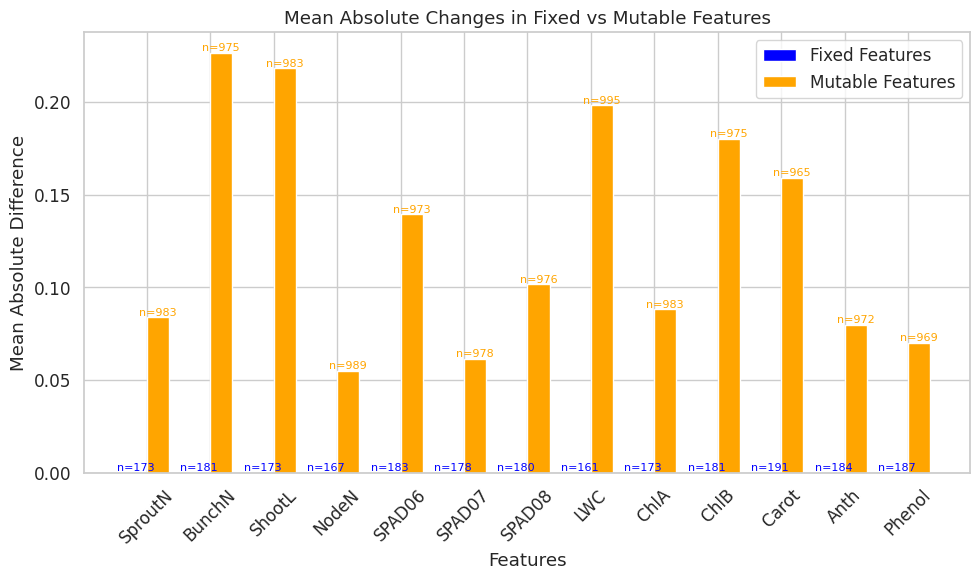

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score
from itertools import combinations
import matplotlib.pyplot as plt

# Constants
N_FEATURES = 13
LATENT_DIM = 15
BINS = 50
LAMBDA_CLASSIFICATION = 20
LAMBDA_MI = 4
LAMBDA_MSE = 0.05
LAMBDA_FIXED = 500
LAMBDA_KL = 0.08
EPOCHS = 100
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
FIXED_SIZE = 2
VAL_SPLIT = 0.1
FEATURE_NAMES = [
    "SproutN", "BunchN", "ShootL", "NodeN", "SPAD06",
    "SPAD07", "SPAD08", "LWC", "ChlA", "ChlB",
    "Carot", "Anth", "Phenol"
]

def load_data():
    """Load Sangiovese dataset from numpy files."""
    data_train = np.load('sangiovese-train-set.npy')
    data_val = np.load('sangiovese-val-set.npy')
    data_test = np.load('sangiovese-test-set.npy')
    
    X_train = data_train[:, :-1]
    y_train = data_train[:, -1]
    X_val = data_val[:, :-1]
    y_val = data_val[:, -1]
    X_test = data_test[:, :-1]
    y_test = data_test[:, -1]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

def compute_feature_weights(X_train):
    """Compute feature weights based on standard deviation."""
    feature_std = np.std(X_train, axis=0)
    return 1.0 / feature_std

def estimate_mi(x, y, bins=BINS):
    """Estimate mutual information between two features using histograms."""
    hist_2d, x_edges, y_edges = np.histogram2d(x, y, bins=bins, density=True)
    p_xy = hist_2d / np.sum(hist_2d)
    p_x = np.sum(p_xy, axis=1)
    p_y = np.sum(p_xy, axis=0)
    p_x_p_y = np.outer(p_x, p_y)
    valid = (p_xy > 0) & (p_x_p_y > 0)
    mi = np.sum(p_xy[valid] * np.log(p_xy[valid] / p_x_p_y[valid]))
    return mi

def compute_mi_and_ranges(X_train, bins=BINS):
    """Precompute mutual information and feature ranges."""
    n_features = X_train.shape[1]
    mi_original = {}
    feature_ranges = {}
    for i, j in combinations(range(n_features), 2):
        mi = estimate_mi(X_train[:, i], X_train[:, j], bins=bins)
        mi_original[(i, j)] = mi
        feature_ranges[(i, j)] = (
            min(X_train[:, i].min(), X_train[:, j].min()),
            max(X_train[:, i].max(), X_train[:, j].max())
        )
    return mi_original, feature_ranges

class MILossLayer(keras.layers.Layer):
    """Custom layer for mutual information loss."""
    def __init__(self, bins, feature_ranges, mi_original_tf, lambda_mi, **kwargs):
        super(MILossLayer, self).__init__(**kwargs)
        self.bins = bins
        self.feature_ranges = feature_ranges
        self.mi_original_tf = mi_original_tf
        self.lambda_mi = lambda_mi

    def call(self, inputs):
        x_recon = inputs
        mi_loss = 0.0
        n_pairs = len(self.mi_original_tf)

        for i, j in combinations(range(x_recon.shape[1]), 2):
            x_i = x_recon[:, i]
            x_j = x_recon[:, j]
            vmin, vmax = self.feature_ranges[(i, j)]
            vmin = tf.constant(vmin, dtype=tf.float32)
            vmax = tf.constant(vmax, dtype=tf.float32)
            bin_edges = tf.linspace(vmin, vmax, self.bins + 1)
            x_i_bin = tf.searchsorted(bin_edges, x_i, side='right') - 1
            x_j_bin = tf.searchsorted(bin_edges, x_j, side='right') - 1
            x_i_bin = tf.clip_by_value(x_i_bin, 0, self.bins - 1)
            x_j_bin = tf.clip_by_value(x_j_bin, 0, self.bins - 1)
            flat_indices = x_i_bin * self.bins + x_j_bin

            hist_1d = tf.math.bincount(
                tf.cast(flat_indices, tf.int32), minlength=self.bins * self.bins, dtype=tf.float32
            )
            hist_2d = tf.reshape(hist_1d, (self.bins, self.bins))
            p_xy = hist_2d / (tf.reduce_sum(hist_2d) + 1e-10)
            p_x = tf.reduce_sum(p_xy, axis=1) + 1e-10
            p_y = tf.reduce_sum(p_xy, axis=0) + 1e-10
            p_x_p_y = tf.expand_dims(p_x, 1) * tf.expand_dims(p_y, 0)
            valid = (p_xy > 1e-10) & (p_x_p_y > 1e-10)
            mi = tf.reduce_sum(tf.where(valid, p_xy * tf.math.log(p_xy / (p_x_p_y + 1e-10)), 0.0))
            mi_loss += tf.abs(mi - self.mi_original_tf[(i, j)])

        mi_loss = mi_loss / n_pairs
        self.add_loss(self.lambda_mi * mi_loss)
        return x_recon

def build_encoder(latent_dim=LATENT_DIM):
    """Build the encoder model."""
    encoder_inputs = keras.Input(shape=(N_FEATURES,), name='X')
    x = keras.layers.Dense(32, activation='relu')(encoder_inputs)
    x = keras.layers.Dense(16, activation='relu')(x)
    mu = keras.layers.Dense(latent_dim, name='mu')(x)
    log_var = keras.layers.Dense(latent_dim, name='log_var')(x)
    return keras.Model(encoder_inputs, [mu, log_var], name='encoder')

def build_decoder(latent_dim=LATENT_DIM):
    """Build the decoder model with actionability."""
    z_inputs = keras.Input(shape=(latent_dim,), name='z')
    t_inputs = keras.Input(shape=(1,), name='t')
    mask_inputs = keras.Input(shape=(N_FEATURES,), name='mask')
    vae_inputs = keras.Input(shape=(N_FEATURES,), name='X_input')
    decoder_inputs = keras.layers.Concatenate(name='decoder_input')([z_inputs, t_inputs])
    x = keras.layers.Dense(16, activation='relu')(decoder_inputs)
    x = keras.layers.Dense(32, activation='relu')(x)
    x_recon = keras.layers.Dense(N_FEATURES, name='X_recon')(x)
    CF = mask_inputs * vae_inputs + (1 - mask_inputs) * x_recon
    return keras.Model([z_inputs, t_inputs, mask_inputs, vae_inputs], [x_recon, CF], name='decoder')

def build_vae(encoder, decoder, clf, mi_original_tf, feature_ranges, 
              lambda_classification=LAMBDA_CLASSIFICATION, lambda_mi=LAMBDA_MI, 
              lambda_mse=LAMBDA_MSE, lambda_fixed=LAMBDA_FIXED, lambda_kl=LAMBDA_KL, 
              bins=BINS):
    """Build and compile the VAE model with actionability."""
    vae_inputs = keras.Input(shape=(N_FEATURES,), name='X_input')
    t_inputs = keras.Input(shape=(1,), name='t_input')
    mask_inputs = keras.Input(shape=(N_FEATURES,), name='mask_input')
    mu, log_var = encoder(vae_inputs)
    epsilon = tf.keras.backend.random_normal(shape=(tf.shape(mu)[0], LATENT_DIM))
    z = mu + tf.exp(0.5 * log_var) * epsilon
    x_recon, CF = decoder([z, t_inputs, mask_inputs, vae_inputs])
    x_recon = MILossLayer(bins=bins, feature_ranges=feature_ranges, 
                          mi_original_tf=mi_original_tf, lambda_mi=lambda_mi)(x_recon)
    vae = keras.Model([vae_inputs, t_inputs, mask_inputs], [x_recon, CF], name='vae')

    # KL Divergence Loss
    kl_loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var), axis=-1)
    vae.add_loss(lambda_kl * tf.reduce_mean(kl_loss))

    # Classification Loss (on CF)
    p = clf(CF)
    classification_loss = tf.keras.losses.sparse_categorical_crossentropy(t_inputs, p)
    vae.add_loss(lambda_classification * tf.reduce_mean(classification_loss))

    # Fixed Feature Reconstruction Loss
    fixed_recon_loss = tf.reduce_mean(mask_inputs * tf.square(vae_inputs - x_recon), axis=-1)
    vae.add_loss(lambda_fixed * tf.reduce_mean(fixed_recon_loss))

    # Mutable Feature Reconstruction Loss
    mutable_recon_loss = tf.reduce_mean((1 - mask_inputs) * tf.square(vae_inputs - x_recon), axis=-1)
    vae.add_loss(lambda_mse * tf.reduce_mean(mutable_recon_loss))

    # Freeze classifier layers
    for layer in clf.layers:
        layer.trainable = False

    vae.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))
    return vae

class PreservationCallback(keras.callbacks.Callback):
    """Callback to monitor fixed feature preservation."""
    def __init__(self, X_val, t_val, mask_val):
        super().__init__()
        self.X_val = X_val
        self.t_val = t_val
        self.mask_val = mask_val
        self.tolerance = 1e-5

    def on_epoch_end(self, epoch, logs=None):
        x_recon_val, CF_val = self.model.predict([self.X_val, self.t_val, self.mask_val], verbose=0)
        diff_cf = np.abs(self.X_val - CF_val) * self.mask_val
        preserved_cf = np.all(diff_cf <= self.tolerance, axis=1)
        preservation_rate_cf = np.mean(preserved_cf)
        diff_recon = np.abs(self.X_val - x_recon_val) * self.mask_val
        preserved_recon = np.all(diff_recon <= self.tolerance, axis=1)
        preservation_rate_recon = np.mean(preserved_recon)
        print(f"Epoch {epoch + 1}: CF Preservation Rate = {preservation_rate_cf:.4f}, x_recon Preservation Rate = {preservation_rate_recon:.4f}")

def evaluate_classifier(clf, X_train, y_train, X_test, y_test):
    """Evaluate the pre-trained classifier."""
    y_train_pred = np.argmax(clf.predict(X_train), axis=1)
    y_test_pred = np.argmax(clf.predict(X_test), axis=1)
    print("Train accuracy:", accuracy_score(y_train, y_train_pred))
    print("Test accuracy:", accuracy_score(y_test, y_test_pred))

def generate_counterfactuals(vae, clf, X_test, y_test, fixed_size=FIXED_SIZE):
    """Generate and verify counterfactuals with actionability."""
    t_test = (1 - np.argmax(clf.predict(X_test), axis=1)).reshape(-1, 1).astype(np.float32)
    mask_test = np.zeros((X_test.shape[0], N_FEATURES), dtype=np.float32)
    cols = np.array([np.random.choice(N_FEATURES, size=fixed_size, replace=False) for _ in range(X_test.shape[0])])
    rows = np.repeat(np.arange(X_test.shape[0]), fixed_size)
    mask_test[rows, cols.flatten()] = 1.0
    outputs = vae.predict([X_test, t_test, mask_test], verbose=0)
    x_recon, X_test_recon = outputs[0], outputs[1]
    original_preds = clf.predict(X_test)
    counterfactual_preds = clf.predict(X_test_recon)
    flip_success = np.mean(np.argmax(counterfactual_preds, axis=1) != np.argmax(original_preds, axis=1))
    print(f"Flip percentage: {flip_success:.4f}")
    if flip_success < 0.5:
        print("Warning: Low flip percentage. Consider relaxing fixed feature constraints.")
    return X_test_recon, t_test, mask_test, np.argmax(original_preds, axis=1), np.argmax(counterfactual_preds, axis=1)

def plot_feature_changes(X_original, X_cf, mask, feature_names=FEATURE_NAMES, save_path='feature_changes.png'):
    """Generate a bar plot showing mean absolute changes in fixed and mutable features."""
    n_features = X_original.shape[1]
    diff = np.abs(X_original - X_cf)
    fixed_diff = np.zeros(n_features)
    mutable_diff = np.zeros(n_features)
    fixed_count = np.zeros(n_features)
    mutable_count = np.zeros(n_features)
    
    for i in range(n_features):
        fixed_mask = mask[:, i] == 1
        mutable_mask = mask[:, i] == 0
        fixed_count[i] = np.sum(fixed_mask)
        mutable_count[i] = np.sum(mutable_mask)
        if fixed_count[i] > 0:
            fixed_diff[i] = np.mean(diff[fixed_mask, i])
        if mutable_count[i] > 0:
            mutable_diff[i] = np.mean(diff[mutable_mask, i])
    
    plt.figure(figsize=(10, 6))
    bar_width = 0.35
    index = np.arange(n_features)
    
    plt.bar(index, fixed_diff, bar_width, label='Fixed Features', color='blue')
    plt.bar(index + bar_width, mutable_diff, bar_width, label='Mutable Features', color='orange')
    
    plt.xlabel('Features')
    plt.ylabel('Mean Absolute Difference')
    plt.title('Mean Absolute Changes in Fixed vs Mutable Features')
    plt.xticks(index + bar_width / 2, feature_names, rotation=45)
    plt.legend()
    plt.tight_layout()
    
    for i in range(n_features):
        plt.text(i, fixed_diff[i], f'n={int(fixed_count[i])}', ha='center', va='bottom', color='blue', fontsize=8)
        plt.text(i + bar_width, mutable_diff[i], f'n={int(mutable_count[i])}', ha='center', va='bottom', color='orange', fontsize=8)

    plt.savefig(save_path)
    plt.show()

def main():
    """Main function to run the pipeline."""
    # Load pre-trained classifier
    clf = keras.models.load_model('classifier_acc_8365.h5')

    # Load and preprocess data
    X_train, y_train, X_val, y_val, X_test, y_test = load_data()
    mi_original, feature_ranges = compute_mi_and_ranges(X_train)
    mi_original_tf = {k: tf.constant(v, dtype=tf.float32) for k, v in mi_original.items()}
    feature_weights = compute_feature_weights(X_train)

    # Evaluate classifier
    evaluate_classifier(clf, X_train, y_train, X_test, y_test)

    # Prepare training data with masks
    t_train = (1 - np.argmax(clf.predict(X_train), axis=1)).reshape(-1, 1).astype(np.float32)
    mask_train = np.zeros((X_train.shape[0], N_FEATURES), dtype=np.float32)
    cols = np.array([np.random.choice(N_FEATURES, size=FIXED_SIZE, replace=False) for _ in range(X_train.shape[0])])
    rows = np.repeat(np.arange(X_train.shape[0]), FIXED_SIZE)
    mask_train[rows, cols.flatten()] = 1.0

    # Split validation data
    n_val = int(X_train.shape[0] * VAL_SPLIT)
    X_val = X_train[-n_val:]
    t_val = t_train[-n_val:]
    mask_val = mask_train[-n_val:]
    X_train = X_train[:-n_val]
    t_train = t_train[:-n_val]
    mask_train = mask_train[:-n_val]

    # Build and train VAE
    encoder = build_encoder()
    decoder = build_decoder()
    vae = build_vae(encoder, decoder, clf, mi_original_tf, feature_ranges)
    
    vae.fit(
        [X_train, t_train, mask_train],
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=([X_val, t_val, mask_val], None),
        callbacks=[PreservationCallback(X_val, t_val, mask_val)],
        verbose=1
    )

    # Generate and visualize counterfactuals
    X_test_recon, t_test, mask_test, original_classes, counterfactual_classes = generate_counterfactuals(vae, clf, X_test, y_test)
    cf_df = pd.DataFrame(X_test_recon, columns=FEATURE_NAMES)
    cf_df.to_csv("counterfactuals_actionable.csv", index=False)
    
    # Plot feature changes
    plot_feature_changes(X_test, X_test_recon, mask_test, save_path='feature_changes_sangiovese.png')

if __name__ == "__main__":
    main()